In [1]:
import torch
import torchvision
import time
import random
import math
import json

from PIL import Image, ImageDraw, ImageFont
from typing import Callable

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
alphabet = ['*','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
random.seed(100)
alphabetColors = [(random.randrange(256),random.randrange(256),random.randrange(256)) for i in alphabet]
def displayCoords(image, coords, labels):
    font = ImageFont.truetype("meiryo.ttc", 20)
    imageCopy = image.copy()
    draw = ImageDraw.Draw(imageCopy)
    for i in range(len(coords)):
        coord = coords[i]
        label = labels[i]
        x1 = coord[0]
        y1 = coord[1]
        x2 = coord[2]
        y2 = coord[3]
        color = alphabetColors[label]
        
        draw.rectangle([x1,y1,x2,y2], outline=color, width=2)
        draw.text((x1+2,y1), alphabet[label], color, font=font)
        
    display(imageCopy)

In [3]:
class imageLoader():
    def __init__(self, list_images_info, batch_size):
        self.resetNeeded = False
        self.selector_index = 0
        self.list_images_info = []
        self.batch_size = batch_size
        self.index_list = [i for i in range(len(list_images_info))]
        random.shuffle(self.index_list)
        self.to_tensor = torchvision.transforms.ToTensor()
        
        
        for i in range(len(list_images_info)):
            self.list_images_info.append({
                'boxes' : torch.FloatTensor(list_images_info[i]['boxes']), 
                'labels' : torch.LongTensor(list_images_info[i]['labels']), 
                'image' : list_images_info[i]['image']}
            )
        
    def needsReset(self)->bool:
        return self.resetNeeded
    
    def reset(self):
        self.selector_index = 0
        random.shuffle(self.index_list)
        self.resetNeeded = False
        
    def getSize(self):
        return len(self.list_images_info)
    
    def getIndexValue(self) -> int:
        return self.selector_index
    
    def getSelectedRandomIndex(self) -> int:
        return self.index_list[self.selector_index]

    def getNextBatch(self):
        true_list_len = len(self.index_list)
        selected_index = -1
        list_len = true_list_len - self.selector_index
        
        selected_indices = []
        while len(selected_indices) < self.batch_size:
            list_len = true_list_len - self.selector_index
            n_to_find = self.batch_size - len(selected_indices)
            start = self.selector_index

            if list_len > n_to_find:
                end = self.selector_index + n_to_find
                selected_indices.extend(self.index_list[start:end])
                self.selector_index += n_to_find
            else:
                self.resetNeeded = True
                selected_indices.extend(self.index_list[start:])
                random.shuffle(self.index_list)
                self.selector_index = 0
        
        list_infos = [{
                        'boxes':self.list_images_info[index]['boxes'].to(device=device),
                        'labels':self.list_images_info[index]['labels'].to(device=device)
        }for index in selected_indices]
                        
        
        start=time.time() #debug
        images = [Image.open(self.list_images_info[index]['image']) for index in selected_indices]
        images = [self.to_tensor(image).to(device=device) for image in images]
        #images = torch.stack(images, dim=0) #Not necessary for FASTERRCNN_RESNET50_FPN
        end=time.time() #debug
        #timeSelectionDataset+=end-start  #debug
        
        
        """
        if self.transform:
            images = self.transform(images)
        if self.target_transform:
            labels = self.target_transform(labels)
        """
        
        return images, list_infos
        

In [4]:
loadingStrings = [' ','▏','▎','▍','▌','▋','▊','▉','█']
def printLoadingBar(percentage:float, length:int, startTime:float):
    if percentage==0.0:
        print(" " + "_"*length)
    
    nbFilled = max(0, min(length, int(length*percentage)))
    remainder = length*percentage - int(length*percentage)
    strRemainder = loadingStrings[int(remainder*len(loadingStrings))]
    strPercentage = "{0:.2f}%".format(100*percentage) 
    isBarFull = int(nbFilled!=length)
    bar = "▕" + "█"*(nbFilled) + isBarFull*strRemainder + " "*(length-nbFilled-1) + "▏" + strPercentage
    
    ellapsedTime = time.time() - startTime
    eta = 0.0 if percentage==0.0 else ellapsedTime*((1-percentage)/percentage)
    isMinute = int(int(eta)>=60)
    isZero = int(int(eta)>1)
    strEta = isMinute*"{0}m".format(int(eta)//60) + isZero*"{0}s".format(int(eta)%60)
    
    buffer = " "*(length+20)
    
    print(buffer,end="\r")
    print(bar + " " + strEta,end="\r")

def train(model, n_epoch, batch_size, lr: Callable[[int], float], images_infos: list):
    
    global timeSelectionDataset
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr(0))
    
    train_separator = int(len(images_infos)*0.5)
    print("Number of picture per epoch : " + str(train_separator) + "\n")
    custom_loader_train = imageLoader(images_infos[:train_separator], batch_size=batch_size)
    custom_loader_eval = imageLoader(images_infos[train_separator+1:], batch_size=batch_size)
    
    frequency_detailed_results = 5
    loadingBarSize = 20
    nPictures = custom_loader_train.getSize()
    
    model_info = model.train()
    
    best_percent = 0
    for epoch in range(n_epoch):
        
        n_correct_1_t = 0
        n_correct_5_t = 0
        n_correct_1_e = 0
        n_correct_5_e = 0
        
        n_total = 0
        t_loss_rpn_pos = 0
        t_loss_rpn_interest = 0
        t_loss_cnn_pos = 0
        t_loss_cnn_class = 0
        
        t_loss_rpn_pos_eval = 0
        t_loss_rpn_interest_eval = 0
        t_loss_cnn_pos_eval = 0
        t_loss_cnn_class_eval = 0
        
        for g in optimizer.param_groups:
            g['lr'] = lr(epoch)
            
        time_select = 0 #debug
        time_model = 0 #debug
        timeSelectionDataset = 0 # debug
        start_epoch = time.time() #debug
            
        print("Epoch " + str(epoch+1))
        custom_loader_train.reset()
        index = 0
        printLoadingBar(0.0,loadingBarSize,start_epoch)
        while not custom_loader_train.needsReset():
            index+=1
            
            model.zero_grad()
            #optimizer.zero_grad() not needed ?
            
            start = time.time() #debug
            images, info_batch = custom_loader_train.getNextBatch()
            end = time.time() #debug
            time_select = end-start # debug
            #print(str(index)+" : Selection time -> " + str(time_select))
            
            start = time.time() #debug
            losses_dict = model(images,info_batch)
            end = time.time() #debug
            time_model = end-start # debug
            #print(str(index)+" : Model time -> " + str(time_model))
            
            t_loss_rpn_pos += losses_dict['loss_rpn_box_reg'].item()
            t_loss_rpn_interest += losses_dict['loss_objectness'].item()
            t_loss_cnn_pos += losses_dict['loss_box_reg'].item()
            t_loss_cnn_class += losses_dict['loss_classifier'].item()
            
            start = time.time() #debug
            
            losses = sum(loss for loss in losses_dict.values())
            losses.backward()
            
            """
            losses['loss_rpn_box_reg'].backward(retain_graph=True)
            losses['loss_objectness'].backward(retain_graph=True)
            losses['loss_box_reg'].backward(retain_graph=True)
            losses['loss_classifier'].backward()
            """
            
            optimizer.step() #Trying at the end of the epoch ?
            end = time.time() #debug
            time_backward = end-start # debug
            #print(str(index)+" : Backward time -> " + str(time_backward))
            
            n_total += batch_size
            percent = n_total/nPictures
            printLoadingBar(percent,loadingBarSize,start_epoch)
            
            if (epoch+1) % frequency_detailed_results == 0:
                with torch.no_grad():
                    images_eval, info_eval = custom_loader_eval.getNextBatch()
                    losses_eval = model(images_eval,info_eval)

                    t_loss_rpn_pos_eval += losses_eval['loss_rpn_box_reg'].item()
                    t_loss_rpn_interest_eval += losses_eval['loss_objectness'].item()
                    t_loss_cnn_pos_eval += losses_eval['loss_box_reg'].item()
                    t_loss_cnn_class_eval += losses_eval['loss_classifier'].item()
        print("")
        
        adjust = 100
        #percent_1_t = math.floor(adjust*100*n_correct_1_t/n_total)/adjust
        #percent_5_t = math.floor(adjust*100*n_correct_5_t/n_total)/adjust
        #percent_1_e = math.floor(adjust*100*n_correct_1_e/n_total)/adjust
        #percent_5_e = math.floor(adjust*100*n_correct_5_e/n_total)/adjust
        
        #display_loss = math.floor(adjust*t_loss)/adjust
        
        #best_percent = percent_5_e if percent_5_e > best_percent else best_percent
        
        end_epoch = time.time()
        time_epoch = end_epoch-start_epoch
        
        
        timeSelection=0
        print("Time epoch : " + str(math.floor(time_epoch*adjust)/adjust) + "s") #debug
        
        #print("\tTime select : " + str(math.floor(time_select*adjust)/adjust)) #debug
        #print("\t - Time select (inside) : " + str(math.floor(timeSelectionDataset*adjust)/adjust)) #debug
        #print("\tTime model : " + str(math.floor(time_model*adjust)/adjust)) #debug
        
        
        timer1 = 0
        timer2 = 0
        timer3 = 0
        
        print("\tavg_loss_rpn_pos : {0:.5f}".format(t_loss_rpn_pos/n_total))
        print("\tavg_loss_rpn_interest : {0:.5f}".format(t_loss_rpn_interest/n_total))
        print("\tavg_loss_cnn_pos : {0:.5f}".format(t_loss_cnn_pos/n_total))
        print("\tavg_loss_cnn_class : {0:.5f}".format(t_loss_cnn_class/n_total))
        
        if (epoch+1) % frequency_detailed_results == 0:
            print("")
            print("\tavg_loss_rpn_pos_eval : {0:.5f}".format(t_loss_rpn_pos_eval/n_total))
            print("\tavg_loss_rpn_interest_eval : {0:.5f}".format(t_loss_rpn_interest_eval/n_total))
            print("\tavg_loss_cnn_pos_eval : {0:.5f}".format(t_loss_cnn_pos_eval/n_total))
            print("\tavg_loss_cnn_class_eval : {0:.5f}".format(t_loss_cnn_class_eval/n_total))
        
        
        print("\n")
        
    return best_percent

In [5]:
#trainModel = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
trainModel = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(
    weights=None,
    num_classes=27, # alphabet+background
    box_detections_per_img=2000
)
n_epochs = 80

#lr: Callable[[int], float] = lambda epoch: 0.0003/(1.03**epoch)
#lr: Callable[[int], float] = lambda epoch: 0.003/(1.15**epoch)
lr: Callable[[int], float] = lambda epoch: 0.0002/(1.03**epoch)

with open('targets.json', 'r', encoding="utf-8") as f:
    infos = json.load(f)
    #train(trainModel, n_epochs, batch_sizes[0], learning_rates[0])
    print("Running on " + device)
    percent = train(trainModel.to(device=device), n_epochs, 10, lr, infos)

Running on cuda
Number of picture per epoch : 2500

Epoch 1
 ____________________
▕████████████████████▏100.00%           
Time epoch : 61.33s
	avg_loss_rpn_pos : 0.00270
	avg_loss_rpn_interest : 0.00828
	avg_loss_cnn_pos : 0.04152
	avg_loss_cnn_class : 0.03973


Epoch 2
 ____________________
▕████████████████████▏100.00%           
Time epoch : 50.8s
	avg_loss_rpn_pos : 0.00133
	avg_loss_rpn_interest : 0.00160
	avg_loss_cnn_pos : 0.03080
	avg_loss_cnn_class : 0.01770


Epoch 3
 ____________________
▕████████████████████▏100.00%           
Time epoch : 48.07s
	avg_loss_rpn_pos : 0.00097
	avg_loss_rpn_interest : 0.00108
	avg_loss_cnn_pos : 0.02838
	avg_loss_cnn_class : 0.01485


Epoch 4
 ____________________
▕████████████████████▏100.00%           
Time epoch : 46.73s
	avg_loss_rpn_pos : 0.00076
	avg_loss_rpn_interest : 0.00080
	avg_loss_cnn_pos : 0.02616
	avg_loss_cnn_class : 0.01229


Epoch 5
 ____________________
▕████████████████████▏100.00%           
Time epoch : 80.3s
	avg_loss_r

KeyboardInterrupt: 

In [ ]:
""" V17 epoch 70
	avg_loss_rpn_pos_eval : 0.00045
	avg_loss_rpn_interest_eval : 0.00054
	avg_loss_cnn_pos_eval : 0.01488
	avg_loss_cnn_class_eval : 0.00686
"""

trainModel.eval()

torch.save(trainModel.cpu(),'./Models/SoulGlyph_Mobile_Model_V17.pt')

torch.save(trainModel.cpu().state_dict(), './Models/SoulGlyph_Mobile_Model_V17.pth')


In [7]:
#evalModel = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(
evalModel = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(
    weights=None,
    num_classes=27,
    box_detections_per_img=2000
)
evalModel.eval()
evalModel.load_state_dict(torch.load("./Models/SoulGlyph_Mobile_Model_V10.pth"))

<All keys matched successfully>

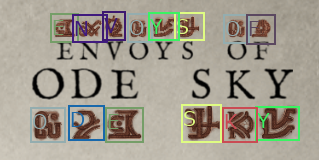

14
tensor([[ 30.5605, 107.5276,  65.3746, 142.9611],
        [255.5936, 106.0038, 299.6512, 140.7789],
        [105.4812, 107.9962, 143.4370, 142.1831],
        [174.1995,  12.0441, 204.4259,  40.9278],
        [222.8898, 107.0100, 257.5136, 142.2187],
        [181.3344, 104.2731, 221.3156, 142.0988],
        [ 50.8615,  13.2848,  78.7315,  42.0323],
        [ 72.8450,  14.2658, 107.8279,  42.8628],
        [127.0574,  13.4831, 152.1063,  42.8443],
        [ 68.5644, 105.6177, 104.4846, 140.8881],
        [148.3700,  12.8103, 179.4322,  40.5244],
        [223.7836,  14.0253, 249.1852,  43.1567],
        [102.5949,  11.0930, 125.9880,  40.8814],
        [246.3685,  14.8826, 275.8551,  44.0300]], grad_fn=<SliceBackward0>)
tensor([15, 25,  5, 19, 11, 19,  5, 14, 15,  4, 25, 15, 22,  6])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9999, 0.9998,
        0.9996, 0.9995, 0.9993, 0.9984, 0.9934], grad_fn=<SliceBackward0>)


In [11]:
def filterResults(result, min_score):
    i = 0
    while i < len(result['scores']) and result['scores'][i] > min_score:
        i+=1
        
    result['boxes'] = result['boxes'][:i]
    result['labels'] = result['labels'][:i]
    result['scores'] = result['scores'][:i]
    

with open('targets.json', 'r', encoding="utf-8") as f:
    #image_nb = 1956
    image_nb = 1944
    infos = json.load(f)
    #test_img = Image.open(infos[image_nb]['image'])
    #test_img = Image.open("./Examples/Poem.PNG")
    test_img = Image.open("./Examples/Envoys.PNG")
    to_tensor = torchvision.transforms.ToTensor()
    test_tensor = to_tensor(test_img)[:3,:,:]
    result = evalModel([test_tensor])
    filterResults(result[0],0.9)
    displayCoords(test_img, result[0]['boxes'].tolist(), result[0]['labels'].tolist())
    print(len(result[0]['boxes']))
    print(result[0]['boxes'])
    print(result[0]['labels'])
    print(result[0]['scores'])